In [1]:
# !pip install torch==1.8.0 torchvision==0.8.2 torchaudio==0.7.2 -f https://download.pytorch.org/whl/torch_stable.html
# !pip install tpu_star==0.0.1rc10
# !pip install albumentations==0.5.2
# !pip install einops==0.3.2 
# !pip install transformers==4.10.0
# !pip install adapter-transformers
# !pip install colorednoise==1.1.1
# !pip install catalyst==21.8 
# !pip install opencv-python==4.5.3
# !pip install gdown==4.0.2
# !pip install pymorphy2

In [2]:
# Доступные ресурсы
import multiprocessing
import torch
from psutil import virtual_memory

ram_gb = round(virtual_memory().total / 1024**3, 1)

print('CPU:', multiprocessing.cpu_count())
print('RAM GB:', ram_gb)

print("PyTorch version:", torch.__version__)
print("CUDA version:", torch.version.cuda)
print("cuDNN version:", torch.backends.cudnn.version())
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("device:", device.type)

!nvidia-smi

CPU: 96
RAM GB: 1510.6
PyTorch version: 1.7.1+cu101
CUDA version: 10.1
cuDNN version: 7603
device: cuda
Tue Nov  2 12:38:13 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 410.129      Driver Version: 410.129      CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM3...  On   | 00000000:B7:00.0 Off |                    0 |
| N/A   30C    P0    49W / 350W |     13MiB / 32480MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+---------------------------------------------------------------

In [3]:
import json
import random
import cv2
import pandas as pd
import numpy as np
import albumentations as A
import IPython.display as ipd
import os
from glob import glob
from datetime import datetime
from skimage import io
from torch import nn
from tqdm import tqdm
from einops import rearrange
from sklearn.metrics import accuracy_score

from transformers import GPT2Model, GPT2Tokenizer

from sklearn.model_selection import StratifiedKFold, train_test_split
from catalyst.data import BalanceClassSampler, DistributedSamplerWrapper
from torch.utils.data import Dataset, DataLoader, SequentialSampler, RandomSampler
from torch.nn.utils.rnn import pad_sequence
from tpu_star.experiment import TorchGPUExperiment
import torch.nn.functional as F

import sys
sys.path.insert(0, 'fusion_brain_aij2021/fb_baseline')
from fb_utils.download import download_and_extract
from fb_utils.loss import LabelSmoothing, onehot
from fb_utils.metrics import cer, wer, string_accuracy, acc, vqa_evaluate, detection_evaluate
from fb_utils.handwritten import simple_detect_lang, CTCLabeling, resize_if_need, make_img_padding
from fb_utils.BLEU import _bleu
from fb_utils.c2c_eval import Beam, eval_bleu

from fb_utils.detection_vqa_htr import (vqa_evaluation, detection_evaluation, htr_evaluation,
                                    CrossAttentionLayer, MLP, FeedForwardComponent, DetectionCriterion)

2021-11-02 12:38:14.590958: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
/home/user/conda/lib/python3.7/site-packages/pymorphy2/units/base.py:70: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  args, varargs, kw, default = inspect.getargspec(cls.__init__)


In [4]:
# Подготовка данных и сбор в единый DataFrame
# #
# Handwritten
# #
json_marking = json.load(open('handwritten/train_labels.json', 'rb'))
marking = []
for image_name, text in json_marking.items():
    marking.append({
        'path': image_name,
        'text': text,
        'lang': simple_detect_lang(text),
    })
df_handwritten = pd.DataFrame(marking)
df_handwritten['stage'] = 'train'
skf = StratifiedKFold(n_splits=10, random_state=42, shuffle=True)
train_index, valid_index = next(skf.split(df_handwritten.index, df_handwritten['lang']))
df_handwritten.loc[valid_index, 'stage'] = 'valid'
# #
# Detection
# #
json_true_zsod = json.load(open('russian_detection_vqa/vg_intersection_eng.json', 'rb'))
json_true_ru_zsod = json.load(open('russian_detection_vqa/vg_intersection_rus.json', 'rb'))
json_true_zsod.update(json_true_ru_zsod)
ru_images = set(json_true_ru_zsod.keys())
marking = []
for image_name in json_true_zsod:
    marking.extend([{
        'task_id': 'detection',
        'path': image_name,
        'req': request,
        'boxes': boxes,
        'lang': 'ru' if image_name in ru_images else 'en'
    } for request, boxes in json_true_zsod[image_name].items() if boxes])
df_detection = pd.DataFrame(marking)
df_detection['stage'] = 'train'
skf = StratifiedKFold(n_splits=10, random_state=42, shuffle=True)
train_index, valid_index = next(skf.split(df_detection.index, df_detection['lang']))
df_detection.loc[valid_index, 'stage'] = 'valid'
# #
# Eval Detection #
# #
valid_detection_images = set(df_detection[df_detection['stage'] == 'valid']['path'])
marking = []
for image_name in json_true_zsod:
    if image_name in valid_detection_images:
        marking.append({
            'task_id': 'detection',
            'path': image_name,
            'req': ';'.join([request for request in json_true_zsod[image_name].keys()]),
            'boxes': [boxes for boxes in json_true_zsod[image_name].values()],
            'lang': 'ru' if image_name in ru_images else 'en'
        })
df_eval_detection = pd.DataFrame(marking)
df_eval_detection['stage'] = 'test'
# #
# VQA
# #
json_questions = json.load(open('train_detection_vqa/vqa_questions.json', 'rb'))
json_true_vqa = json.load(open('train_detection_vqa/vqa_answers.json', 'rb'))
marking = []
for key in json_questions:
    if json_true_vqa[key]['lang'] == 'en':
        marking.append({
            'path': json_questions[key]['file_name'],
            'question': json_questions[key]['question'],
            'answer': json_true_vqa[key]['answer'],
            'lang': json_true_vqa[key]['lang']
        })
df_vqa = pd.DataFrame(marking)
df_vqa['stage'] = 'train'
skf = StratifiedKFold(n_splits=10, random_state=42, shuffle=True)
train_index, valid_index = next(skf.split(df_vqa.index, df_vqa['lang']))
df_vqa.loc[valid_index, 'stage'] = 'valid'
# #
# C2C
# #
df_c2c = pd.read_json(path_or_buf='c2c/java-python.jsonl', lines=True)
train, test = train_test_split(df_c2c, test_size=0.2)
valid, test = train_test_split(test, test_size=0.05)

df_c2c.loc[train.index.to_list(), 'stage'] = 'train'
df_c2c.loc[valid.index.to_list(), 'stage'] = 'valid'
df_c2c.loc[test.index.to_list(), 'stage'] = 'test'


# #
# Merge in common set
# #
dataset = []
for lang, image_name, text, stage in zip(df_handwritten['lang'], df_handwritten['path'], df_handwritten['text'], df_handwritten['stage']):
    dataset.append({
        'task_id': 'handwritten',   
        'modality': 'image',
        'lang': lang,
        'input_image': image_name,
        'output_text': text,
        'stage': stage,
    })
    
for java, python, stage in zip(df_c2c['java'], df_c2c['python'], df_c2c['stage']):
    dataset.append({
        'task_id': 'trans',
        'modality': 'code',
        'input_text': java,
        'output_text': python,
        'stage': stage,
    })
    
for lang, image_name, text_input, text_output, stage in zip(df_vqa['lang'], df_vqa['path'], df_vqa['question'], df_vqa['answer'], df_vqa['stage']):
    dataset.append({
        'task_id': 'vqa', 
        'modality': 'image+text',
        'lang': lang,
        'input_image': image_name,
        'input_text': text_input,
        'output_text': text_output,
        'stage': stage,
    })
for lang, image_name, text_input, boxes, stage in zip(df_detection['lang'], df_detection['path'], df_detection['req'], df_detection['boxes'], df_detection['stage']):
    dataset.append({
        'task_id': 'detection', 
        'modality': 'image+text',
        'lang': lang,
        'input_image': image_name,
        'input_text': text_input,
        'output_boxes': boxes,
        'stage': stage,
    })
for lang, image_name, text_input, boxes, stage in zip(df_eval_detection['lang'], df_eval_detection['path'], df_eval_detection['req'], df_eval_detection['boxes'], df_eval_detection['stage']):
    dataset.append({
        'task_id': 'detection', 
        'modality': 'image+text',
        'lang': lang,
        'input_image': image_name,
        'input_text': text_input,
        'output_boxes': boxes,
        'stage': stage,
    })

random.shuffle(dataset)
df = pd.DataFrame(dataset)
df.head(10)

,task_id,modality,lang,input_image,input_text,output_text,stage,output_boxes
0,vqa,image+text,en,2334634.jpg,How many people are in this picture?,one,train,NaN
1,detection,image+text,en,2327362.jpg,green and wite signpost,NaN,train,"[[89.0, 407.0, 127.0, 92.0]]"
2,detection,image+text,en,2375174.jpg,yellow bag under cat,NaN,train,"[[32.0, 228.0, 297.0, 113.0]]"
3,detection,image+text,en,2333039.jpg,pointed white ear with black,NaN,valid,"[[140.0, 140.0, 35.0, 26.0]]"
4,detection,image+text,en,2342071.jpg,black roman numerals on white clock,NaN,train,"[[160.0, 163.0, 33.0, 37.0]]"
5,vqa,image+text,en,2375875.jpg,Who is looking at the camera?,the cat,train,NaN
6,detection,image+text,en,2356404.jpg,barber wears a blue striped shirt,NaN,train,"[[273.0, 63.0, 225.0, 307.0]]"
7,vqa,image+text,en,2333096.jpg,What is the object on the tracks?,a train,train,NaN
8,detection,image+text,ru,2402391.jpg,полосатый самолет в небе,NaN,train,"[[170.0, 91.0, 207.0, 97.0]]"
9,detection,image+text,en,2345347.jpg,person has skis on feet,NaN,train,"[[359.0, 297.0, 62.0, 51.0]]"


<AxesSubplot:>

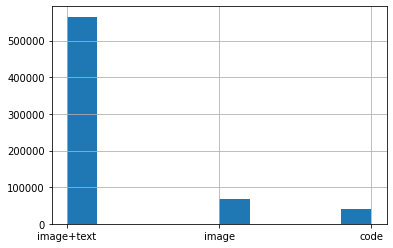

In [5]:
df['modality'].hist()

In [6]:
class DatasetRetriever(Dataset):

    def __init__(self, 
                 task_ids, 
                 input_images,
                 input_texts,
                 output_texts,
                 output_boxes,
                 tokenizer, 
                 stage,
                 handwritten_max_tokens_length,
                 max_request_tokens_length,
                 vqa_max_tokens_length, 
                 task_augs=None):
        super().__init__()
        self.task_ids = task_ids
        
        self.input_images = input_images
        self.input_texts = input_texts
        self.output_texts = output_texts
        
        self.task_augs = task_augs or {}
        self.tokenizer = tokenizer
        self.stage = stage

        # handwritten[image]:
        self.handwritten_max_tokens_length = handwritten_max_tokens_length
        self.handwritten_image_w = 512
        self.handwritten_image_h = 128

        # code2code
        self.code_max_length = 512
        
        # detection[image, text]:
        self.max_request_tokens_length = max_request_tokens_length
        self.output_boxes = output_boxes
        
        # vqa[image, text]:
        self.vqa_max_tokens_length = vqa_max_tokens_length


    def __getitem__(self, idx):
        task_id = self.task_ids[idx]
        if task_id == 'handwritten':
            return self.get_handwritten_sample(idx)
        elif task_id == 'trans':
            return self.get_trans_sample(idx)
        elif task_id == 'detection':
            return self.get_detection_sample(idx)
        elif task_id == 'vqa':
            return self.get_vqa_sample(idx)
        return {'task_id': task_id}

    def get_trans_sample(self, idx):
            
        source = self.input_texts[idx]
        encoded_source = self.tokenizer.encode(str(source))
        target = self.output_texts[idx]
        encoded_target = self.tokenizer.encode(str(target))
        
        input_ids, input_labels = self.pad_and_get_mask(encoded_target, encoded_source, self.tokenizer)
        input_ids, input_labels = torch.tensor(input_ids), torch.tensor(input_labels)
        
        return {
            'task_id': self.task_ids[idx],
            'input_ids': input_ids,
            'input_labels': input_labels,
            'target': target
        }

    def get_handwritten_sample(self, idx):
        path = 'handwritten/images/' + self.input_images[idx]
        image = cv2.imread(path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image, _ = self.resize_image(image)

        gt_text = self.output_texts[idx]
        tokens = self.tokenizer.encode(gt_text)[:6]
        encoded = [self.tokenizer.bos_token_id] + tokens + [self.tokenizer.eos_token_id]
        labels = [2] * (len(tokens) + 1) + [0]
        
        pad_len = self.handwritten_max_tokens_length - len(encoded)
        encoded += [self.tokenizer.pad_token_id] * pad_len
        labels += [0] * pad_len

        ## Augs ##
        transforms = self.task_augs.get('handwritten')
        if transforms:
            image = transforms(image=image)['image']
        ##########

        image = image.astype(np.float32) / 255.0
        image = torch.from_numpy(image).permute(2, 0, 1)

        return {
            'task_id': self.task_ids[idx],
            'image': image,
            'gt_text': gt_text,
            'labels': torch.tensor(labels),
            'encoded': torch.tensor(encoded),
        }
    
    def get_detection_sample(self, idx):
        path = 'russian_detection_vqa/images/' + self.input_images[idx]
        image = cv2.imread(path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image_h, image_w, _ = image.shape
        
        ## Augs ##
        transforms = self.task_augs.get('detection')
        if transforms:
            image = transforms(image=image)['image']
        image = image.astype(np.float32) / 255.0
        image = torch.from_numpy(image).permute(2, 0, 1)
        image_name = self.input_images[idx]
        ##########
        
        ## Input tokens ##
        if self.stage == 'train' or self.stage == 'valid':
            input_text = self.input_texts[idx]
            input_tokens = self.tokenizer.encode_plus(input_text)
            input_tokens['input_ids'] = input_tokens['input_ids'][:21]
            input_tokens['attention_mask'] = input_tokens['attention_mask'][:21]
            pad_len = self.max_request_tokens_length - len(input_tokens['input_ids'])
            input_tokens['input_ids'] += [self.tokenizer.pad_token_id] * pad_len
            input_tokens['attention_mask'] += [0] * pad_len
            input_ids = torch.tensor(input_tokens['input_ids'])
            attention_mask = torch.tensor(input_tokens['attention_mask'])
        else:
            input_texts = self.input_texts[idx].split(';')
            input_ids = list(map(self.tokenizer.encode, input_texts))
            attention_mask = [[1 for _ in input_token] for input_token in input_ids]
            input_ids = [torch.tensor(input_id) for input_id in input_ids]
            attention_mask = [torch.tensor(mask) for mask in attention_mask]
        ###########
        
        ## Boxes ##
        output_boxes = self.output_boxes[idx]
        if self.stage == 'train' or self.stage == 'valid':
            output_boxes = torch.tensor(output_boxes, dtype=torch.float32)
            output_boxes[:, 0] /= image_w
            output_boxes[:, 1] /= image_h
            output_boxes[:, 2] /= image_w
            output_boxes[:, 3] /= image_h
        else:
            output_boxes = {
                input_text: boxes for input_text, boxes in zip(input_texts, output_boxes)
            }
        ##########
        
        return {
            'task_id': self.task_ids[idx],
            'image_name': image_name,
            'image': image,
            'input_ids': input_ids,
            'attention_mask': attention_mask,
            'boxes': output_boxes,
            'size': (image_h, image_w)
        }
    
    def get_vqa_sample(self, idx): 
        path = 'train_detection_vqa/images/' + self.input_images[idx]
        image = cv2.imread(path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        ## Augs ##
        transforms = self.task_augs.get('vqa')
        if transforms:
            image = transforms(image=image)['image']
        image = image.astype(np.float32) / 255.0
        image = torch.from_numpy(image).permute(2, 0, 1)
        image_name = self.input_images[idx]
        ##########
        
        ## Question and Answer ##
        input_text = self.input_texts[idx]
        input_tokens = self.tokenizer.encode(input_text)
        output_text = self.output_texts[idx]
        output_tokens = self.tokenizer.encode(output_text)
        
        if self.stage == 'train' or self.stage == 'valid':
            input_tokens, output_tokens = input_tokens[:12], output_tokens[:7]
            input_ids = input_tokens + [self.tokenizer.bos_token_id] + output_tokens + [self.tokenizer.eos_token_id]
            labels = [1] * len(input_tokens) + [2] * (len(output_tokens) + 1) + [0]
            
            pad_len = self.vqa_max_tokens_length - len(input_ids)
            input_ids += [self.tokenizer.pad_token_id] * pad_len
            labels += [0] * pad_len
        else:
            input_ids = input_tokens + [self.tokenizer.bos_token_id]
            labels = [1] * len(input_tokens) + [2]
        ##########
        
        return {
            'task_id': self.task_ids[idx],
            'image_name': image_name,
            'image': image,
            'input_ids': torch.tensor(input_ids),
            'labels': torch.tensor(labels),
            'target': output_text
        }


    def resize_image(self, image):
        image, coef = resize_if_need(image, self.handwritten_image_h, self.handwritten_image_w)
        image = make_img_padding(image, self.handwritten_image_h, self.handwritten_image_w)
        return image, coef
    
    def pad_and_get_mask(self, target, source, tokenizer):
        if self.stage == 'test':
            target = []
        while len(target) + len(source) + 2 > self.code_max_length:
            if len(target) > len(source):
                target = target[:-1]
            else:
                source = source[:-1]
        if self.stage == 'train' or self.stage == 'valid':
            inputs = source + [tokenizer.bos_token_id] + target + [tokenizer.eos_token_id]
            labels = [1] * len(source) + [2] * (len(target) + 1) + [0]

        else:
            inputs = source + [tokenizer.bos_token_id]
            labels = [1] * len(source) + [2]
            
            return inputs, labels
        
        assert len(inputs) <= self.code_max_length
        pad_len = self.code_max_length - len(inputs)
        inputs += [tokenizer.pad_token_id] * pad_len
        labels += [0] * pad_len
        assert len(inputs) == len(labels)
        
        return inputs, labels

 
    def __len__(self) -> int:
        return self.task_ids.shape[0]

    def get_task_labels(self):
        return list(self.task_ids)

In [7]:
task_augs = {
    'handwritten': A.Compose([
        A.CLAHE(clip_limit=4.0, tile_grid_size=(8, 8), p=0.25, always_apply=False),
        A.Rotate(limit=3, interpolation=1, border_mode=0, p=0.5),
        A.JpegCompression(quality_lower=75, p=0.5),
    ], p=1.0),
    'vqa': A.Compose([
        A.Resize(224, 224, always_apply=True),
        A.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ], p=1.0),
    'detection': A.Compose([
        A.Resize(224, 224, always_apply=True),
        A.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ], p=1.0)
}

/home/user/conda/lib/python3.7/site-packages/albumentations/augmentations/transforms.py:1748: DeprecationWarning: This class has been deprecated. Please use ImageCompression
  warnings.warn("This class has been deprecated. Please use ImageCompression", DeprecationWarning)


In [8]:
df_train = df[df['stage'] == 'train']
df_valid = df[df['stage'] == 'valid']
df_eval = df[df['stage'] == 'test']

In [9]:
model_name = "sberbank-ai/rugpt3small_based_on_gpt2"
gpt_tokenizer = GPT2Tokenizer.from_pretrained(model_name, bos_token='<s>',
            eos_token='</s>', pad_token='<pad>', unk_token='<|UNKNOWN|>', sep_token='<|SEP|>')

gpt_model = GPT2Model.from_pretrained(model_name)
gpt_model.resize_token_embeddings(len(gpt_tokenizer))

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Some weights of the model checkpoint at sberbank-ai/rugpt3small_based_on_gpt2 were not used when initializing GPT2Model: ['lm_head.weight']
- This IS expected if you are initializing GPT2Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing GPT2Model from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Embedding(50258, 768)

In [10]:
train_dataset = DatasetRetriever(
    task_ids=df_train['task_id'].values,
    input_images=df_train['input_image'].values,
    input_texts=df_train['input_text'].values,
    output_texts=df_train['output_text'].values,
    output_boxes=df_train['output_boxes'].values,
    stage='train',
    tokenizer=gpt_tokenizer,
    handwritten_max_tokens_length=8,
    max_request_tokens_length=21,
    vqa_max_tokens_length=21,
    task_augs=task_augs,
)
valid_dataset = DatasetRetriever(
    task_ids=df_valid['task_id'].values,
    input_images=df_valid['input_image'].values,
    input_texts=df_valid['input_text'].values,
    output_texts=df_valid['output_text'].values,
    output_boxes=df_valid['output_boxes'].values,
    stage='valid',
    tokenizer=gpt_tokenizer,
    handwritten_max_tokens_length=8,
    max_request_tokens_length=21,
    vqa_max_tokens_length=21,
    task_augs=task_augs,
)
eval_dataset = DatasetRetriever(
    task_ids=df_eval['task_id'].values,
    input_images=df_eval['input_image'].values,
    input_texts=df_eval['input_text'].values,
    output_texts=df_eval['output_text'].values,
    output_boxes=df_eval['output_boxes'].values,
    stage='test',
    tokenizer=gpt_tokenizer,
    handwritten_max_tokens_length=8,
    max_request_tokens_length=21,
    vqa_max_tokens_length=21,
    task_augs=task_augs,
)

In [11]:
# Как выглядят семплы для каждой задачи
def demo_sample(sample):
    if sample['task_id'] == 'handwritten':
        print('[gt_text]:',sample['gt_text'])
        return io.imshow(sample['image'].permute(1,2,0).numpy())
    elif sample['task_id'] == 'trans':
        print('[source_text]:', gpt_tokenizer.decode(sample['input_ids'].numpy(), skip_special_tokens=True))
        print('[target_text]:', sample['target'])
        return
    elif sample['task_id'] == 'detection':
        print('[input_text]:', gpt_tokenizer.decode(sample['input_ids'].numpy(), skip_special_tokens=True))
        print('[boxes]:', sample['boxes'].numpy())
        return
    elif sample['task_id'] == 'vqa':
        print('[question and answer]:', gpt_tokenizer.decode(sample['input_ids'].numpy(), skip_special_tokens=True))
        return
    
    return sample

In [12]:
demo_sample(train_dataset[(train_dataset.task_ids == 'detection').argmax()])

[input_text]: green and wite signpost
[boxes]: [[0.23733333 0.814      0.33866668 0.184     ]]


In [13]:
demo_sample(train_dataset[(train_dataset.task_ids == 'trans').argmax()])

[source_text]: import java. util. Scanner ; import java. io. PrintStream ; import java. io. OutputStream ; import java. io. IOException ; import java. io. FileOutputStream ; import java. util. Arrays ; import java. io. PrintWriter ; import java. io. FileInputStream ; import java. io. InputStream ; public class Main { public static void main ( String [ ] args ) { InputStream inputStream ; try { inputStream = new FileInputStream ( " gcj1. in " ) ; } catch ( IOException e ) { throw new RuntimeException ( e ) ; } OutputStream outputStream ; try { outputStream = new FileOutputStream ( " gcj1. out " ) ; } catch ( IOException e ) { throw new RuntimeException (dictionary = {'a':'y ','b':'h ','c':'e ','d':'s ','e':'o ','f':'c ','g':'v ','h':'x ','i':'d ','j':'u ','k':'i ','l':'g ','m':'l ','n':'b ','o':'k ','p':'r ','q':'z ','r':'t ','s':'n ','t':'w ','u':'j ','v':'p ','w':'f ','x':'m ','y':'a ','z':'q'} NEW_LINE def process_file ( file ) : NEW_LINE INDENT fsock = open ( file ) NE
[target_text]

In [14]:
demo_sample(train_dataset[(train_dataset.task_ids == 'vqa').argmax()])

[question and answer]: How many people are in this picture?one


[gt_text]: Вариант


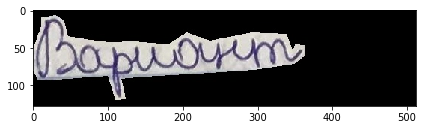

In [15]:
demo_sample(train_dataset[(train_dataset.task_ids == 'handwritten').argmax()])

In [16]:
def fb_collate_fn(batch):
    """ fusion brain collate fn """
    encoded, htr_labels, htr_images, gt_texts = [], [], [], [] # handwritten[image]
    code_input_ids, code_input_labels, code_targets = [], [], [] #code
    vqa_images, vqa_input_ids, labels, targets = [], [], [], []  # vqa[image, text]
    detection_names, detection_images, detection_input_ids, detection_attention_masks, boxes, size = [], [], [], [], [], [] # detection[image, text]
    
    for i, sample in enumerate(batch):
        if sample['task_id'] == 'handwritten':
            encoded.append(sample['encoded'])
            htr_labels.append(sample['labels'])
            htr_images.append(sample['image'])
            gt_texts.append(sample['gt_text'])
        elif sample['task_id'] == 'trans':
            code_input_ids.append(sample['input_ids'])
            code_input_labels.append(sample['input_labels'])
            code_targets.append(sample['target'])
        elif sample['task_id'] == 'detection':
            detection_images.append(sample['image'])
            detection_input_ids.append(sample['input_ids'])
            detection_attention_masks.append(sample['attention_mask'])
            boxes.append(sample['boxes'])
            size.append(sample['size'])
            detection_names.append(sample['image_name'])
        elif sample['task_id'] == 'vqa':
            vqa_images.append(sample['image'])
            vqa_input_ids.append(sample['input_ids'])
            labels.append(sample['labels'])
            targets.append(sample['target'])
        
    if htr_images:
        htr_images = pad_sequence(htr_images, batch_first=True)
        encoded = torch.stack(encoded)
        htr_labels = torch.stack(htr_labels)
    if detection_images:
        detection_images = torch.stack(detection_images)   
    if vqa_images:
        vqa_images = torch.stack(vqa_images) 
    if detection_attention_masks and torch.is_tensor(detection_attention_masks[0]):
        detection_input_ids = pad_sequence(detection_input_ids, batch_first=True)
        detection_attention_masks = torch.stack(detection_attention_masks)
    elif detection_attention_masks:
        detection_input_ids = [input_id.unsqueeze(0) for input_id in detection_input_ids[0]]
        detection_attention_masks = [attention_mask.unsqueeze(0) for attention_mask in detection_attention_masks[0]]
    if labels:
        vqa_input_ids = pad_sequence(vqa_input_ids, batch_first=True)
        labels = pad_sequence(labels, batch_first=True)    
    if code_input_ids:
        code_input_ids = pad_sequence(code_input_ids, batch_first=True)
        code_input_labels = pad_sequence(code_input_labels, batch_first=True)
    return (htr_images, encoded, htr_labels, gt_texts), (code_input_ids, code_input_labels, code_targets), (vqa_images, vqa_input_ids, labels, targets), (detection_names, detection_images, detection_input_ids, detection_attention_masks, boxes, size)

In [17]:
class GPT2FusionBrain(nn.Module):

    def __init__(self, 
                 gpt_model, 
                 attention_config, 
                 handwritten_config, 
                 vqa_config, 
                 detection_config, 
                 **freeze_gpt_kwargs):
        super().__init__()
        self.gpt_model = gpt_model
        self.embedding_size = self.gpt_model.config.n_embd
        self.freeze_gpt(**freeze_gpt_kwargs)

        # handwritten[image] input/output layers:
        self.handwritten_config = handwritten_config
        self.handwritten_input_layer = self._build_input_net(
            input_dim=handwritten_config['patch_w']*handwritten_config['patch_h']*3,
            in_layer_sizes=handwritten_config['in_layer_sizes'],
            orth_gain=handwritten_config['orth_gain'],
            dropout=handwritten_config['dropout'],
        )
        self.htr_tokens_embed = nn.Linear(self.embedding_size, self.gpt_model.config.vocab_size, bias=False)
        print('=== HANDWRITTEN TASK ===')
        self._calculate_trainable_params([
            self.handwritten_input_layer,
            self.gpt_model, 
        ], without_emb=True)
        print('=== === === === ===')
        #####

        # code2code
        self.beam_size=3
        self.sos_id=self.gpt_model.config.bos_token_id
        self.eos_id=self.gpt_model.config.eos_token_id
        self.lm_head = nn.Linear(self.gpt_model.config.n_embd, self.gpt_model.config.vocab_size, bias=False)

        print('=== C2C TASK ===')
        self._calculate_trainable_params([self.gpt_model, self.lm_head])
        print('=== === === === ===')
        
        ## zhOD[image, text] and VQA[image, text] layers:
        self.attention_config = attention_config
        self.cross_attention = nn.ModuleList([
            CrossAttentionLayer(self.embedding_size, attention_config['num_heads'], attention_config['pf_dim'])
            for _ in range(attention_config['num_attention_layers'])
        ])
        #####
        
        # detection[image, text] input/output layers:
        self.detection_config = detection_config
        self.detection_input_image_layer = self._build_input_net(
            input_dim=detection_config['patch_w']*detection_config['patch_h']*3,
            in_layer_sizes=detection_config['in_layer_sizes'],
            orth_gain=detection_config['orth_gain'],
            dropout=detection_config['dropout'],
        )
        self.detection_pool = nn.AdaptiveMaxPool2d((detection_config["num_queries"], None))
        self.bbox_embed = MLP(self.embedding_size, self.embedding_size, 5, detection_config['num_mlp_layers'])
        print('=== DETECTION TASK ===')
        self._calculate_trainable_params([
            self.detection_input_image_layer,
            self.gpt_model,
            self.cross_attention,
            self.bbox_embed
        ], without_emb=True)
        print('=== === === === ===')
        #####
        
         # vqa[image, text] input/output layers:
        self.vqa_config = vqa_config
        self.vqa_input_image_layer = self._build_input_net(
            input_dim=vqa_config['patch_w']*vqa_config['patch_h']*3,
            in_layer_sizes=vqa_config['in_layer_sizes'],
            orth_gain=vqa_config['orth_gain'],
            dropout=vqa_config['dropout'],
        )
        self.tokens_embed = nn.Linear(self.embedding_size, self.gpt_model.config.vocab_size, bias=False)
        print('=== VQA TASK ===')
        self._calculate_trainable_params([
            self.vqa_input_image_layer,
            self.gpt_model, 
            self.cross_attention,
            self.tokens_embed
        ], without_emb=True)
        print('=== === === === ===')
        #####
        
        print('=== COMMON PARAMS ===')
        self._calculate_common_params()
        print('=== === === === ===')


    def forward(self, task_id, **kwargs):
        if task_id == 'handwritten':
            return self.forward_handwritten(**kwargs)
        elif task_id == 'trans':
            return self.forward_trans(**kwargs)
        elif task_id == 'vqa':
            return self.forward_vqa(**kwargs)
        elif task_id == 'detection':
            return self.forward_detection(**kwargs)

    def forward_trans(self, input_ids, input_labels=None, eval_bleu=False, past=None):
        if not eval_bleu:
            attn_mask = torch.tensor(input_labels.clone().detach() != 0, dtype=torch.uint8)
            attn_mask = attn_mask.to(input_labels.device)
            outputs = self.gpt_model(input_ids, attention_mask=attn_mask)
            x = self.lm_head(outputs[0])
            return x
        else:
            if past != None:
                outputs = self.gpt_model(input_ids, past_key_values=past)
                logits = self.lm_head(outputs[0])
                return logits, outputs[1]
            else:
                outputs = self.gpt_model(input_ids)[1]
                return outputs

    def forward_handwritten(self, images, target, labels):
        patchs = rearrange(images, 'b c (h p1) (w p2) -> b (w) (h) (p1 p2 c)',
                      p1=self.handwritten_config['patch_h'], p2=self.handwritten_config['patch_w'])
        patchs = patchs.squeeze(2)
        patchs = self.handwritten_input_layer(patchs)
        
        tokens_emb = self.gpt_model.wte(target)
        tokens_emb = self.gpt_model.drop(tokens_emb)
        
        input_emb = torch.cat((patchs, tokens_emb), dim=1)
        attention_mask = torch.tensor(labels.clone().detach() != 0, dtype=torch.uint8)
        attention_mask = attention_mask.to(labels.device)
        # Fusion Brain
        gpt_output = self.gpt_model(inputs_embeds=input_emb, attention_mask=attention_mask).last_hidden_state
        #####
        output_logits = self.htr_tokens_embed(gpt_output)

        return output_logits

    def forward_vqa(self, images, tokens, labels):
        patchs = rearrange(images, 'b c (h p1) (w p2) -> b (w) (h) (p1 p2 c)',
                      p1=self.vqa_config['patch_h'], p2=self.vqa_config['patch_w'])
        patchs = patchs.squeeze(2)
        patchs = self.vqa_input_image_layer(patchs)
        attention_mask = torch.tensor(labels.clone().detach() != 0, dtype=torch.uint8)
        attention_mask = attention_mask.to(labels.device)
        # Fusion Brain
        img_emb = self.gpt_model(inputs_embeds=patchs).last_hidden_state
        tokens_emb = self.gpt_model(input_ids=tokens, attention_mask=attention_mask).last_hidden_state
        #####
        for layer in self.cross_attention:
            tokens_emb, _ = layer(tokens_emb, img_emb)
            
        output_logits = self.tokens_embed(tokens_emb)
        
        return output_logits
    
    def forward_detection(self, images, tokens, attention_masks):
        patchs = rearrange(images, 'b c (h p1) (w p2) -> b (w) (h) (p1 p2 c)',
                      p1=self.detection_config['patch_h'], p2=self.detection_config['patch_w'])
        patchs = patchs.squeeze(2)
        patchs = self.detection_input_image_layer(patchs)
        # Fusion Brain
        img_embs = self.gpt_model(inputs_embeds=patchs).last_hidden_state
        tokens_embs = self.gpt_model(input_ids=tokens, attention_mask=attention_masks).last_hidden_state
        #####
        norm_img_embs = F.normalize(img_embs, p=2, dim=-1)
        norm_tokens_embs = F.normalize(tokens_embs, p=2, dim=-1)
        
        text_masks = attention_masks.type(torch.bool)
        for layer in self.cross_attention:
            img_embs, _ = layer(img_embs, tokens_embs, ~text_masks)
        img_embs = self.detection_pool(img_embs)
        
        output_logits = self.bbox_embed(img_embs).sigmoid()
        out = {
            'pred_logits': output_logits,
            'proj_queries': norm_img_embs,
            'proj_tokens':norm_tokens_embs,
        }

        return out

    def freeze_gpt(self, freeze_pos=True, freeze_ln=True, freeze_attn=True, freeze_ff=True, freeze_other=True):
        for name, p in self.gpt_model.named_parameters():
            name = name.lower()
            if 'ln' in name or 'norm' in name:
                p.requires_grad = not freeze_ln
            elif 'wpe' in name or 'position_embeddings' in name or 'pos_drop' in name:
                p.requires_grad = not freeze_pos
            elif 'mlp' in name:
                p.requires_grad = not freeze_ff
            elif 'attn' in name:
                p.requires_grad = not freeze_attn
            else:
                p.requires_grad = not freeze_other

    def _build_input_net(self, input_dim, in_layer_sizes=None, orth_gain=1.41, dropout=0.1):
        """ вспомогательный метод для сборки input слоя, который приводит размер входящих данный к эмбеддингу gpt """
        in_layer_sizes = [] if not in_layer_sizes else in_layer_sizes
        in_layers = []
        last_output_size = input_dim
        for size in in_layer_sizes:
            layer = nn.Linear(last_output_size, size)
            if orth_gain is not None:
                torch.nn.init.orthogonal_(layer.weight, gain=orth_gain)
            layer.bias.data.zero_()

            in_layers.append(layer)
            in_layers.append(nn.ReLU())
            in_layers.append(nn.Dropout(dropout))
            last_output_size = size

        final_linear = nn.Linear(last_output_size, self.embedding_size)
        if orth_gain is not None:
            torch.nn.init.orthogonal_(final_linear.weight, gain=orth_gain)
        final_linear.bias.data.zero_()

        in_layers.append(final_linear)
        in_layers.append(nn.Dropout(dropout))

        return nn.Sequential(*in_layers)

    def _calculate_trainable_params(self, layers, without_emb=False):
        trainable_params, all_used_params = 0, 0
        for layer in layers:
            trainable_params += sum(p.numel() for p in layer.parameters() if p.requires_grad)
            all_used_params += sum(p.numel() for p in layer.parameters())        
        print('trainable_params:', trainable_params)
        print(' all_used_params:', all_used_params)
        print('               %:', round(trainable_params/all_used_params*100, 2))

    def _calculate_common_params(self):
        all_params = sum(p.numel() for p in self.parameters())
        trainable_params = sum(p.numel() for p in self.parameters() if p.requires_grad)
        common_params = sum(p.numel() for p in list(self.gpt_model.parameters()))
        print('common_params:', common_params)
        print('   all_params:', all_params)
        print('            %:', round(common_params/all_params*100, 2))     
        print('trainable_params:', trainable_params)
        print('               %:', round(trainable_params/all_params*100, 2))

In [18]:
handwritten_config = {
    'patch_w': 8,
    'patch_h': 128,
    'in_layer_sizes': [8*128*3],
    'orth_gain': 1.41,
    'dropout': 0.1,
}

attention_config = {
    'num_attention_layers': 3,
    'num_heads': 8,
    'pf_dim': 2048,
}

vqa_config = {
    'patch_w': 4,
    'patch_h': 224,
    'in_layer_sizes': [4*224*3],
    'out_layer_sizes': [64],
    'orth_gain': 1.41,
    'dropout': 0.1,
    'tokens_num': len(gpt_tokenizer),
}

detection_config = {
    'patch_w': 4,
    'patch_h': 224,
    'in_layer_sizes': [4*224*3],
    'out_layer_sizes': [64],
    'orth_gain': 1.41,
    'dropout': 0.1,
    'num_mlp_layers': 3,
    'num_queries': 8
}

In [19]:
model = GPT2FusionBrain(
    gpt_model,
    attention_config=attention_config,
    handwritten_config=handwritten_config,
    vqa_config=vqa_config,
    detection_config=detection_config
)

=== HANDWRITTEN TASK ===
trainable_params: 11800320
 all_used_params: 137027328
               %: 8.61
=== === === === ===
=== C2C TASK ===
trainable_params: 38598144
 all_used_params: 163825152
               %: 23.56
=== === === === ===
=== DETECTION TASK ===
trainable_params: 27020165
 all_used_params: 152247173
               %: 17.75
=== === === === ===
=== VQA TASK ===
trainable_params: 64433280
 all_used_params: 189660288
               %: 33.97
=== === === === ===
=== COMMON PARAMS ===
common_params: 125227008
   all_params: 289135109
            %: 43.31
trainable_params: 163908101
               %: 56.69
=== === === === ===


# Lehas Experiments

In [20]:
# Скрипты для обучения и оценки качества модели


class FusionBrainExperiment(TorchGPUExperiment):

    handwritten_criterion = nn.CrossEntropyLoss()
    detection_criterion = DetectionCriterion(['boxes', 'classification', 'contrastive'], 0.07)
    detection_loss_weights = [1.0, 1.0, 1.0, 1.0]
    vqa_criterion = nn.CrossEntropyLoss()
    c2c_criterion = nn.CrossEntropyLoss()
    tokenizer = GPT2Tokenizer.from_pretrained('gpt2', bos_token='<s>',
            eos_token='</s>', pad_token='<pad>', unk_token='<|UNKNOWN|>', sep_token='<|SEP|>')
    
#     def custom_action_before_train_one_epoch(self, test_loader):
#         run_evaluation(test_loader, self.model, tokenizer=self.tokenizer)
        
#     def _custom_action_before_train_one_epoch(self):
#         self._wipe_memory()
#         self.custom_action_before_train_one_epoch(test_loader)

    def calculate_handwritten_metrics(self, gt_texts, outputs):
        pred_texts = []
        for encoded in outputs.argmax(2).data.cpu().numpy():
            pred_texts.append(self.ctc_labeling.decode(encoded))
        texts = [self.ctc_labeling.preprocess(text) for text in gt_texts]
        return {
            'h_cer': cer(pred_texts, texts),
            'h_wer': wer(pred_texts, texts),
            'h_acc': string_accuracy(pred_texts, texts),
        }

    def handle_one_batch(self, batch):
        (htr_images, encoded, htr_labels, gt_texts), (code_input_ids, code_input_labels, code_targets), (vqa_images, vqa_input_ids, labels, targets), (detection_names, detection_images, detection_input_ids, detection_attention_masks, boxes, size) = batch
        losses = []
        metrics = {}

        if len(htr_images) > 0:
            bs = htr_images.shape[0]
            images = htr_images.to(self.device, dtype=torch.float32)
            encoded = encoded.to(self.device, dtype=torch.long)
            htr_labels = htr_labels.to(self.device, dtype=torch.long)
            image_labels = torch.ones(bs, 64).to(self.device, dtype=torch.long)
            all_labels = torch.cat((image_labels, htr_labels), dim=-1)
            loss_mask = torch.tensor(htr_labels == 2, dtype=torch.uint8)
            loss_mask = loss_mask.to(self.device)
            logits = self.model('handwritten', images=images, target=encoded, labels=all_labels)
            shift_logits = logits[..., 64:-1, :].contiguous()
            shift_labels = encoded[..., 1:].contiguous()
            
            flatten_shift_loss_mask = loss_mask[..., :-1].contiguous().view(-1)
            ids = torch.nonzero(flatten_shift_loss_mask).view(-1)
            handwritten_loss = self.handwritten_criterion(shift_logits.view(-1, shift_logits.size(-1))[ids], shift_labels.view(-1)[ids])
            metrics['h_loss'] = handwritten_loss.detach().cpu().item()
            losses.append(handwritten_loss)

        if len(code_input_ids) > 0:
            bs = code_input_ids.shape[0]
            code_input_ids = code_input_ids.to(self.device, dtype=torch.long) 
            code_input_labels = code_input_labels.to(self.device, dtype=torch.long) 
            loss_mask = torch.tensor(code_input_labels.clone().detach() == 2, dtype=torch.uint8)
            loss_mask = loss_mask.to(self.device)
            lm_logits = self.model('trans', input_ids=code_input_ids, input_labels=code_input_labels)
            c_labels = code_input_ids
            shift_logits = lm_logits[..., :-1, :].contiguous()
            shift_labels = c_labels[..., 1:].contiguous()
            
            flatten_shift_loss_mask = loss_mask[..., :-1].contiguous().view(-1)
            ids = torch.nonzero(flatten_shift_loss_mask).view(-1)
            c2c_loss = self.c2c_criterion(shift_logits.view(-1, shift_logits.size(-1))[ids], shift_labels.view(-1)[ids])
            metrics['c2c_loss'] = c2c_loss.detach().cpu().item()
            losses.append(c2c_loss)
            
        if len(labels) > 0:
            images = vqa_images.to(self.device, dtype=torch.float32)
            input_ids = vqa_input_ids.to(self.device, dtype=torch.long)
            labels = labels.to(self.device, dtype=torch.float32)
            loss_mask = torch.tensor(labels.clone().detach() == 2, dtype=torch.uint8)
            loss_mask = loss_mask.to(self.device)
            lm_logits = self.model('vqa', images=images, tokens=input_ids, labels=labels)
            labels = input_ids
            shift_logits = lm_logits[..., :-1, :].contiguous()
            shift_labels = labels[..., 1:].contiguous()

            flatten_shift_loss_mask = loss_mask[..., :-1].contiguous().view(-1)
            ids = torch.nonzero(flatten_shift_loss_mask).view(-1)
            vqa_loss = self.vqa_criterion(shift_logits.view(-1, shift_logits.size(-1))[ids], shift_labels.view(-1)[ids])
            metrics['vqa_loss'] = vqa_loss.detach().cpu().item()
            losses.append(vqa_loss)
            
        if len(boxes) > 0:
            images = detection_images.to(self.device, dtype=torch.float32)
            input_ids = detection_input_ids.to(self.device, dtype=torch.long) 
            attention_masks = detection_attention_masks.to(self.device, dtype=torch.long) 
            boxes = [boxes_per_label.to(self.device, dtype=torch.float) for boxes_per_label in boxes]
            detection_outputs = self.model('detection', images=images, tokens=input_ids, attention_masks=attention_masks)
            detection_loss = self.detection_criterion(detection_outputs, boxes)
            #detection_loss = sum([
            #    loss * weight for loss, weight in zip(detection_loss.values(), self.detection_loss_weights)
            #])
            #metrics['detection_acc'] = acc(targets.argmax(axis=1), sentiment_outputs)
            metrics['loss_giou'] = detection_loss['loss_giou'].detach().cpu().item()
            metrics['loss_bbox'] = detection_loss['loss_bbox'].detach().cpu().item()
            metrics['loss_contrastive'] = detection_loss['loss_contrastive'].detach().cpu().item()
            metrics['loss_classification'] = detection_loss['loss_classification'].detach().cpu().item()
            losses.append(detection_loss['loss_giou'])
            losses.append(detection_loss['loss_bbox'])
            losses.append(detection_loss['loss_contrastive'])
            losses.append(detection_loss['loss_classification'])

        #loss = sum(losses)
        loss = sum([loss * weight for loss, weight in zip(losses, self.detection_loss_weights)])
        
        #print(loss)
        self.metrics.update(loss=loss.detach().cpu().item(), **metrics)
        
        #self.metrics.update(loss=loss.item(), **metrics)

        if self.is_train:
            loss.backward()
            self.optimizer_step()
            self.optimizer.zero_grad()
            self.scheduler.step()


def run_evaluation(loader, model, tokenizer=None, device=torch.device('cuda:0')):
    result = []
    true_json_detection = {}
    pred_json_detection = {}
    model.to(device)
    model.eval()
    with torch.no_grad():
        for batch in tqdm(loader):
            (htr_images, encoded, htr_labels, gt_texts), (code_input_ids, code_input_labels, code_targets), (vqa_images, vqa_input_ids, labels, targets), (detection_names, detection_images, detection_input_ids, detection_attention_masks, boxes, size) = batch
            if len(htr_images) > 0:
                bs = htr_images.shape[0]
                images = htr_images.to(device, dtype=torch.float32)
                attention_mask = torch.ones(bs, 65).to(device, dtype=torch.long)
                tokens = torch.tensor([[gpt_tokenizer.bos_token_id]]).repeat(bs, 1)
                tokens = tokens.to(device, dtype=torch.long)
                handwritten_outputs = htr_evaluation(model, images, attention_mask, tokens, 6)
                for encoded, gt_text in zip(handwritten_outputs.argmax(2).data.cpu().numpy(), gt_texts):
                    pred_text = gpt_tokenizer.decode(encoded, skip_special_tokens=True)
                    result.append({
                        'task_id': 'handwritten',
                        'gt_output': gt_text,
                        'pred_output': pred_text,
                    })

            if len(code_input_ids) > 0:
                code_input_ids = code_input_ids.to(device, dtype=torch.long)
                code_input_labels = code_input_labels.to(device, dtype=torch.long)
                loss_mask = torch.tensor(code_input_labels.clone().detach() == 2, dtype=torch.uint8)
                loss_mask = loss_mask.to(device)
                hidden_states = model('trans', input_ids=code_input_ids, input_labels=code_input_labels, eval_bleu=True)
                bleu_score, _ = eval_bleu(model, hidden_states, input_ids=code_input_ids, beam_size=5, tokenizer=tokenizer, targets=code_targets)
                result.append({
                        'task_id': 'trans',
                        'true_text': code_targets,
                        'bleu_score': bleu_score,
                })
                
            if len(labels) > 0:
                images = vqa_images.to(device, dtype=torch.float32)
                input_ids = vqa_input_ids.to(device, dtype=torch.long)
                labels = labels.to(device, dtype=torch.float) 
                attention_mask = torch.tensor(labels.clone().detach() != 0, dtype=torch.uint8)
                attention_mask = attention_mask.to(labels.device)
                vqa_outputs = vqa_evaluation(model, images, input_ids, attention_mask, 10)
                for target, pred_labels in zip(targets, vqa_outputs.argmax(-1).cpu().numpy()):
                    result.append({
                        'task_id': 'vqa',
                        'gt_output': target,
                        'pred_output': gpt_tokenizer.decode(pred_labels, skip_special_tokens=True).split(gpt_tokenizer.eos_token)[0],
                    })
                    
            if len(boxes) > 0:
                images = detection_images.to(device, dtype=torch.float32)
                input_ids = [input_id.to(device, dtype=torch.long) for input_id in detection_input_ids]
                attention_masks = [attention_mask.to(device, dtype=torch.long) for attention_mask in detection_attention_masks]
                detection_outputs = detection_evaluation(model, images, input_ids, attention_masks, 0.12, 0.5)
                img_h, img_w = size[0]
                for i in range(len(detection_outputs)):
                    if detection_outputs[i].numel() != 0:
                        detection_outputs[i][:, 0] = detection_outputs[i][:, 0] * img_w
                        detection_outputs[i][:, 2] = detection_outputs[i][:, 2] * img_w
                        detection_outputs[i][:, 1] = detection_outputs[i][:, 1] * img_h
                        detection_outputs[i][:, 3] = detection_outputs[i][:, 3] * img_h
                image_name = detection_names[0]
                for boxes_for_img in boxes:
                    true_json_detection[image_name] = boxes_for_img
                    pred_json_detection[image_name] = {
                        input_text: output.type(torch.int32).cpu().tolist()
                        for input_text, output in zip(boxes_for_img.keys(), detection_outputs)
                    }
                result.append({
                        'task_id': 'detection',
                    })
                
    result = pd.DataFrame(result)

    handwritten_result = result[result['task_id'] == 'handwritten']
    if handwritten_result.shape[0]:
        print('= Handwritten =')
        print('CER:', round(cer(handwritten_result['pred_output'], handwritten_result['gt_output']), 3))
        print('WER:', round(wer(handwritten_result['pred_output'], handwritten_result['gt_output']), 3))
        print('ACC:', round(string_accuracy(handwritten_result['pred_output'], handwritten_result['gt_output']), 3))
        print('=== === === ===')
        
    trans_result = result[result['task_id'] == 'trans']   
    if trans_result.shape[0]:
        print('== C2C ==')
        print('meanBLEU:', np.mean(trans_result['bleu_score']))
        print('=== === === ===')
        
    vqa_result = result[result['task_id'] == 'vqa']
    if vqa_result.shape[0]:
        print('== VQA ==')
        print('ACC:', round(vqa_evaluate(vqa_result), 3))
        print('=== === === ===')
        
    
    if len(true_json_detection):
        print('== Detection ==')
        #print(true_json_detection)
        #print("PRED")
        #print(pred_json_detection)
        print('ACC:', round(detection_evaluate(true_json_detection, pred_json_detection), 3))
        print('=== === === ===')

    return result


def load_model(model, experiment_name):
    paths = sorted(glob(f'./saved_models/{experiment_name}*'))
    if len(paths) == 0:
        print('Warning! Model not found')
        return model
    checkpoint_path = paths[-1] + '/last.pt'
    checkpoint = torch.load(checkpoint_path, map_location='cpu')
    model.load_state_dict(checkpoint['model_state_dict'], strict=False)
#     metrics = defaultdict(list)
#     for epoch in range(len(checkpoint['metrics_state_dict']['train_metrics'])):
#         train_metrics = checkpoint['metrics_state_dict']['train_metrics'][epoch]['avg']
#         valid_metrics = checkpoint['metrics_state_dict']['valid_metrics'][epoch]['avg']
#         for key in train_metrics.keys():
#             metrics[f'train_{key}'].append(train_metrics[key])
#             metrics[f'valid_{key}'].append(valid_metrics[key])
#         metrics['epoch'].append(epoch)        
#     metrics = pd.DataFrame(metrics)
    return model
#     return model

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [22]:
#@title c2c evaluation
vqa_valid = df[(df['task_id'] == 'vqa') & (df['stage'] == 'valid')][:200]

vqa_eval_dataset = DatasetRetriever(
    task_ids=vqa_valid['task_id'].values,
    input_images=vqa_valid['input_image'].values,
    input_texts=vqa_valid['input_text'].values,
    output_texts=vqa_valid['output_text'].values,
    output_boxes=vqa_valid['output_boxes'].values,
    stage='test',
    handwritten_max_tokens_length=8,
    tokenizer=gpt_tokenizer,
    max_request_tokens_length=21,
    vqa_max_tokens_length=21,
    task_augs=task_augs,
)

#model = load_model(model, 'fusion-brain-vqa')
model = model.to(device)
model.load_state_dict(torch.load('saved_models/fusion-brain-handwritten-1635813348/last.pt')['model_state_dict'])

valid_loader = torch.utils.data.DataLoader(
    vqa_eval_dataset,
    batch_size=1,
    sampler=SequentialSampler(vqa_eval_dataset),
    pin_memory=False,
    drop_last=False,
    num_workers=2,
    collate_fn=fb_collate_fn,
)

evaluation_result = run_evaluation(valid_loader, model, tokenizer=gpt_tokenizer)

100%|██████████| 200/200 [00:27<00:00,  7.34it/s]

== VQA ==
ACC: 0.0
=== === === ===


## Code To Code

In [ ]:
# Запуск обучения c2c[code]

DEMO_LOGS = False 

trans_train = df[(df['task_id'] == 'trans') & (df['stage'] == 'train')]
trans_valid = df[(df['task_id'] == 'trans') & (df['stage'] == 'valid')]
trans_test = df[(df['task_id'] == 'trans') & (df['stage'] == 'test')]


trans_train_dataset = DatasetRetriever(
    task_ids=trans_train['task_id'].values,
    input_images=trans_train['input_image'].values,
    input_texts=trans_train['input_text'].values,
    output_texts=trans_train['output_text'].values,
    output_boxes=trans_train['output_boxes'].values,
    ctc_labeling=ctc_labeling,
    tokenizer=gpt_tokenizer,
    stage='train',
    max_request_tokens_length=21,
    vqa_max_tokens_length=21,
    task_augs=task_augs,
)

trans_valid_dataset = DatasetRetriever(
    task_ids=trans_valid['task_id'].values,
    input_images=trans_valid['input_image'].values,
    input_texts=trans_valid['input_text'].values,
    output_texts=trans_valid['output_text'].values,
    output_boxes=trans_valid['output_boxes'].values,
    ctc_labeling=ctc_labeling,
    tokenizer=gpt_tokenizer,
    stage='valid',
    max_request_tokens_length=21,
    vqa_max_tokens_length=21,
    task_augs=task_augs,
)

trans_test_dataset = DatasetRetriever(
    task_ids=trans_test['task_id'].values,
    input_images=trans_test['input_image'].values,
    input_texts=trans_test['input_text'].values,
    output_texts=trans_test['output_text'].values,
    output_boxes=trans_test['output_boxes'].values,
    ctc_labeling=ctc_labeling,
    tokenizer=gpt_tokenizer,
    stage='test',
    max_request_tokens_length=21,
    vqa_max_tokens_length=21,
    task_augs=task_augs,
)


#model.freeze_gpt()
model.freeze_gpt(freeze_pos=False, freeze_ln=False, freeze_attn=True, freeze_ff=True, freeze_other=False)

CONFIG = {
    'description': 'Обучение c2c task',
    'experiment_name': f'fusion-brain-c2c-{round(datetime.utcnow().timestamp())}',
    'lr': 0.000005,
    'bs': 4,
    'num_epochs': 25,
    'max_lr': 0.001,
    'pct_start': 0.1,
}

device = torch.device('cuda:0')

train_loader = torch.utils.data.DataLoader(
    trans_train_dataset,
    batch_size=CONFIG['bs'],
    sampler=RandomSampler(trans_train_dataset),
    pin_memory=False,
    drop_last=True,
    num_workers=2,
    collate_fn=fb_collate_fn,
)
valid_loader = torch.utils.data.DataLoader(
    trans_valid_dataset,
    batch_size=CONFIG['bs'],
    sampler=SequentialSampler(trans_valid_dataset),
    pin_memory=False,
    drop_last=False,
    num_workers=2,
    collate_fn=fb_collate_fn,
)
test_loader = torch.utils.data.DataLoader(
    trans_test_dataset,
    batch_size=1,
    sampler=SequentialSampler(trans_test_dataset),
    pin_memory=False,
    drop_last=False,
    num_workers=2,
    collate_fn=fb_collate_fn,
)

model = model.to(device)


optimizer = torch.optim.AdamW(model.parameters(), lr=CONFIG['lr'])
scheduler = torch.optim.lr_scheduler.OneCycleLR(
    optimizer,
    max_lr=CONFIG['max_lr'],
    steps_per_epoch=len(train_loader), 
    pct_start=CONFIG['pct_start'],
    epochs=CONFIG['num_epochs'],
)

if DEMO_LOGS:
    print(open('./saved_models/fusion-brain-detection-1631794561/log.txt').read())
else:
    experiment = FusionBrainExperiment(
        model=model,
        optimizer=optimizer,
        criterion=None,
        scheduler=scheduler,
        device=device,
        base_dir=f'./saved_models',
        experiment_name=CONFIG['experiment_name'],
        verbose_step=10**5,
        seed=42,
        best_saving=False,
        last_saving=True,
        #test_loader=test_loader #before each epoch BLEU is calculated (custom_action_before_train_one_epoch in Experiment)
    )
    experiment.fit(train_loader, valid_loader, CONFIG['num_epochs'])
    experiment.destroy()

## Handwritten

In [ ]:
# @title Запуск обучения handwritten[image]

DEMO_LOGS = False #@param {type:"boolean"}

handwritten_train = df[(df['task_id'] == 'handwritten') & (df['stage'] == 'train')]
handwritten_valid = df[(df['task_id'] == 'handwritten') & (df['stage'] == 'valid')]

handwritten_train_dataset = DatasetRetriever(
    task_ids=handwritten_train['task_id'].values,
    input_images=handwritten_train['input_image'].values,
    input_texts=handwritten_train['input_text'].values,
    output_texts=handwritten_train['output_text'].values,
    output_boxes=handwritten_train['output_boxes'].values,
    tokenizer=gpt_tokenizer,
    stage='train',
    handwritten_max_tokens_length=8,
    max_request_tokens_length=21,
    vqa_max_tokens_length=21,
    task_augs=task_augs,
)
handwritten_valid_dataset = DatasetRetriever(
    task_ids=handwritten_valid['task_id'].values,
    input_images=handwritten_valid['input_image'].values,
    input_texts=handwritten_valid['input_text'].values,
    output_texts=handwritten_valid['output_text'].values,
    output_boxes=handwritten_valid['output_boxes'].values,
    tokenizer=gpt_tokenizer,
    stage='valid',
    handwritten_max_tokens_length=8,
    max_request_tokens_length=21,
    vqa_max_tokens_length=21,
    task_augs=task_augs,
)

CONFIG = {
    'description': 'Обучение handwritten task',
    'experiment_name': f'fusion-brain-handwritten-{round(datetime.utcnow().timestamp())}',
    'lr': 0.00008,
    'bs': 64,
    'num_epochs': 50,
    'max_lr': 0.001,
    'pct_start': 0.1,
}

device = torch.device('cuda:0')

train_loader = torch.utils.data.DataLoader(
    handwritten_train_dataset,
    batch_size=CONFIG['bs'],
    sampler=RandomSampler(handwritten_train_dataset),
    pin_memory=False,
    drop_last=True,
    num_workers=4,
    collate_fn=fb_collate_fn,
)
valid_loader = torch.utils.data.DataLoader(
    handwritten_valid_dataset,
    batch_size=CONFIG['bs'],
    sampler=SequentialSampler(handwritten_valid_dataset),
    pin_memory=False,
    drop_last=False,
    num_workers=4,
    collate_fn=fb_collate_fn,
)

model.freeze_gpt()
model = model.to(device)
#model.load_state_dict(torch.load('MainWeights/c2c_handwritten.pt')['model_state_dict'])

optimizer = torch.optim.AdamW(model.parameters(), lr=CONFIG['lr'])
scheduler = torch.optim.lr_scheduler.OneCycleLR(
    optimizer,
    max_lr=CONFIG['max_lr'],
    steps_per_epoch=len(train_loader), 
    pct_start=CONFIG['pct_start'],
    epochs=CONFIG['num_epochs'],
)

if DEMO_LOGS:
    print(open('./saved_models/fusion-brain-handwritten-1631797524/log.txt').read())
else:
    experiment = FusionBrainExperiment(
        model=model,
        optimizer=optimizer,
        criterion=None,
        scheduler=scheduler,
        device=device,
        base_dir=f'./saved_models',
        experiment_name=CONFIG['experiment_name'],
        verbose_step=10**5,
        seed=42,
        best_saving=True,
        last_saving=True,
    )
    experiment.fit(train_loader, valid_loader, CONFIG['num_epochs'])
    experiment.destroy()

## VQA

In [ ]:
# Запуск обучения vqa[image+text]

DEMO_LOGS = False

vqa_train = df[(df['task_id'] == 'vqa') & (df['stage'] == 'train')]
vqa_valid = df[(df['task_id'] == 'vqa') & (df['stage'] == 'valid')]

vqa_train_dataset = DatasetRetriever(
    task_ids=vqa_train['task_id'].values,
    input_images=vqa_train['input_image'].values,
    input_texts=vqa_train['input_text'].values,
    output_texts=vqa_train['output_text'].values,
    output_boxes=vqa_train['output_boxes'].values,
    ctc_labeling=ctc_labeling,
    tokenizer=gpt_tokenizer,
    stage='train',
    max_request_tokens_length=21,
    vqa_max_tokens_length=21,
    task_augs=task_augs,
)
vqa_valid_dataset = DatasetRetriever(
    task_ids=vqa_valid['task_id'].values,
    input_images=vqa_valid['input_image'].values,
    input_texts=vqa_valid['input_text'].values,
    output_texts=vqa_valid['output_text'].values,
    output_boxes=vqa_valid['output_boxes'].values,
    ctc_labeling=ctc_labeling,
    tokenizer=gpt_tokenizer,
    stage='valid',
    max_request_tokens_length=21,
    vqa_max_tokens_length=21,
    task_augs=task_augs,
)

model.freeze_gpt(freeze_pos=False, freeze_ln=False, freeze_attn=True, freeze_ff=True, freeze_other=False)

CONFIG = {
    'description': 'Обучение vqa task',
    'experiment_name': f'fusion-brain-vqa-{round(datetime.utcnow().timestamp())}',
    'lr': 0.000004,
    'bs': 64,
    'num_epochs': 20,
    'max_lr': 0.001,
    'pct_start': 0.1,
}

device = torch.device('cuda:0')

train_loader = torch.utils.data.DataLoader(
    vqa_train_dataset,
    batch_size=CONFIG['bs'],
    sampler=RandomSampler(vqa_train_dataset),
    pin_memory=False,
    drop_last=True,
    num_workers=0,
    collate_fn=fb_collate_fn,
)
valid_loader = torch.utils.data.DataLoader(
    vqa_valid_dataset,
    batch_size=CONFIG['bs'],
    sampler=SequentialSampler(vqa_valid_dataset),
    pin_memory=False,
    drop_last=False,
    num_workers=0,
    collate_fn=fb_collate_fn,
)

model = model.to(device)
#model.load_state_dict(torch.load('MainWeights/c2c_handwritten.pt'), strict=False)

optimizer = torch.optim.AdamW(model.parameters(), lr=CONFIG['lr'])
scheduler = torch.optim.lr_scheduler.OneCycleLR(
    optimizer,
    max_lr=CONFIG['max_lr'],
    steps_per_epoch=len(train_loader), 
    pct_start=CONFIG['pct_start'],
    epochs=CONFIG['num_epochs'],
)

if DEMO_LOGS:
    print(open('./saved_models/fusion-brain-vqa-1631794561/log.txt').read())
else:
    experiment = FusionBrainExperiment(
        model=model,
        optimizer=optimizer,
        criterion=None,
        scheduler=scheduler,
        device=device,
        base_dir=f'./saved_models',
        experiment_name=CONFIG['experiment_name'],
        verbose_step=10**5,
        seed=42,
        best_saving=True,
        last_saving=True,
    )
    experiment.fit(train_loader, valid_loader, CONFIG['num_epochs'])
    experiment.destroy()

## Detection

In [2]:
# Запуск обучения detection[image+text]

DEMO_LOGS = False

detection_train = df[(df['task_id'] == 'detection') & (df['stage'] == 'train')]
detection_valid = df[(df['task_id'] == 'detection') & (df['stage'] == 'valid')]

detection_train_dataset = DatasetRetriever(
    task_ids=detection_train['task_id'].values,
    input_images=detection_train['input_image'].values,
    input_texts=detection_train['input_text'].values,
    output_texts=detection_train['output_text'].values,
    output_boxes=detection_train['output_boxes'].values,
    stage='train',
    ctc_labeling=ctc_labeling,
    tokenizer=gpt_tokenizer,
    max_request_tokens_length=21,
    vqa_max_tokens_length=21,
    task_augs=task_augs,
)
detection_valid_dataset = DatasetRetriever(
    task_ids=detection_valid['task_id'].values,
    input_images=detection_valid['input_image'].values,
    input_texts=detection_valid['input_text'].values,
    output_texts=detection_valid['output_text'].values,
    output_boxes=detection_valid['output_boxes'].values,
    stage='valid',
    ctc_labeling=ctc_labeling,
    tokenizer=gpt_tokenizer,
    max_request_tokens_length=21,
    vqa_max_tokens_length=21,
    task_augs=task_augs,
)

model.freeze_gpt(freeze_pos=True, freeze_ln=False, freeze_attn=True, freeze_ff=True, freeze_other=False)

CONFIG = {
    'description': 'Обучение detection task',
    'experiment_name': f'fusion-brain-detection-{round(datetime.utcnow().timestamp())}',
    'lr': 0.000004,
    'bs': 32,
    'num_epochs': 60,
    'max_lr': 0.0001,
    'pct_start': 0.1,
}

device = torch.device('cuda:0')

train_loader = torch.utils.data.DataLoader(
    detection_train_dataset,
    batch_size=CONFIG['bs'],
    sampler=RandomSampler(detection_train_dataset),
    pin_memory=False,
    drop_last=True,
    num_workers=0,
    collate_fn=fb_collate_fn,
)
valid_loader = torch.utils.data.DataLoader(
    detection_valid_dataset,
    batch_size=CONFIG['bs'],
    sampler=SequentialSampler(detection_valid_dataset),
    pin_memory=False,
    drop_last=False,
    num_workers=0,
    collate_fn=fb_collate_fn,
)

model = model.to(device)
#model.load_state_dict(torch.load('MainWeights/c2c_handwritten_vqa.pt'), strict=False)

optimizer = torch.optim.AdamW(model.parameters(), lr=CONFIG['lr'])
scheduler = torch.optim.lr_scheduler.OneCycleLR(
    optimizer,
    max_lr=CONFIG['max_lr'],
    steps_per_epoch=len(train_loader), 
    pct_start=CONFIG['pct_start'],
    epochs=CONFIG['num_epochs'],
)

if DEMO_LOGS:
    print(open('./saved_models/fusion-brain-detection-1631794561/log.txt').read())
else:
    experiment = FusionBrainExperiment(
        model=model,
        optimizer=optimizer,
        criterion=None,
        scheduler=scheduler,
        device=device,
        base_dir=f'./saved_models',
        experiment_name=CONFIG['experiment_name'],
        verbose_step=10**5,
        seed=42,
        best_saving=True,
        last_saving=True,
    )
    experiment.fit(train_loader, valid_loader, CONFIG['num_epochs'])
    experiment.destroy()

NameError: name 'df' is not defined

## Fusion Brain

In [3]:
# @title Запуск обучения fusion brain [text, image]

DEMO_LOGS = False #@param {type:"boolean"}

CONFIG = {
    'description': 'Fusion Brain',
    'experiment_name': f'fusion-brain-main-{round(datetime.utcnow().timestamp())}',
    'lr': 0.00008,
    'bs': 64,
    'num_epochs': 20,
    'max_lr': 0.00004,
    'pct_start': 0.1,
    'final_div_factor': 100
}

device = torch.device('cuda:0')

train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=CONFIG['bs'],
    sampler=BalanceClassSampler(labels=train_dataset.get_task_labels()),
    pin_memory=False,
    drop_last=True,
    num_workers=2,
    collate_fn=fb_collate_fn,
)
valid_loader = torch.utils.data.DataLoader(
    valid_dataset,
    batch_size=CONFIG['bs'],
    sampler=BalanceClassSampler(labels=valid_dataset.get_task_labels()),
    pin_memory=False,
    drop_last=False,
    num_workers=2,
    collate_fn=fb_collate_fn,
)

model.freeze_gpt(False, False, False, False, False)
model = model.to(device)
model.load_state_dict(torch.load('MainWeights/c2c_handwritten.pt'), strict=False)


optimizer = torch.optim.AdamW(model.parameters(), lr=CONFIG['lr'])
scheduler = torch.optim.lr_scheduler.OneCycleLR(
    optimizer,
    max_lr=CONFIG['max_lr'],
    steps_per_epoch=len(train_loader), 
    pct_start=CONFIG['pct_start'],
    epochs=CONFIG['num_epochs'],
    final_div_factor=CONFIG['final_div_factor'],
)

if DEMO_LOGS:
    print(open('./saved_models/fusion-brain-main-1631924391/log.txt').read())
else:
    experiment = FusionBrainExperiment(
        model=model,
        optimizer=optimizer,
        criterion=None,
        scheduler=scheduler,
        device=device,
        base_dir=f'./saved_models',
        experiment_name=CONFIG['experiment_name'],
        verbose_step=10**5,
        seed=42,
        best_saving=True,
        last_saving=True,
    )
    experiment.fit(train_loader, valid_loader, CONFIG['num_epochs'])
    experiment.destroy()

NameError: name 'datetime' is not defined